# HDBSCAN Clustering for Betacov sequences
---
### DEMO
https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html#sphx-glr-auto-examples-cluster-plot-hdbscan-py
--- 
### Parquet Making
We will be making a parquet for the entire file. Then we can sample from it randomly.

Making the parquet.

In [86]:
import os
import sys
import torch
import time
import datetime
import pandas as pd
from torch.utils.data import Dataset, DataLoader

from transformers import EsmTokenizer, EsmForMaskedLM

import lightning as L

# Parquet Making
class BetaCovDataset(Dataset):
    """ BetaCorona virus sequence dataset, embedded with ESM model. """

    def __init__(self, csv_file:str):
        try:
            self.df = pd.read_csv(csv_file, sep=',', header=0, na_filter=False)
        except (FileNotFoundError, pd.errors.ParserError, Exception) as e:
            print(f"Error reading in .csv file: {csv_file}\n{e}", file=sys.stderr)
            sys.exit(1)

        self.df['variant'] = self.df['variant'].replace({
            'MERS': 'MERSV',
            'Sars-Cov-1': 'SARS-CoV-1',
            'Sars-Cov-2': 'SARS-CoV-2'
        })

        self.max_len = self.df['sequence'].apply(len).max()

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx):
        return self.df.iloc[idx]["seq_id"], self.df.iloc[idx]["variant"], self.df.iloc[idx]["host"], self.df.iloc[idx]["sequence"]

class BetaCovDataModule(L.LightningDataModule):
    def __init__(self, data_dir: str, batch_size: int, num_workers: int, seed: int):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed

        # Set seeds globally for reproducibility
        L.seed_everything(self.seed, workers=True)

    def setup(self, stage):
        # Called on every GPU
        if stage == 'test':
            self.test_dataset = BetaCovDataset(os.path.join(self.data_dir, "betacoronavirus_seq.csv"))

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            drop_last=False, 
            num_workers=self.num_workers,
            generator=torch.Generator().manual_seed(self.seed),
            pin_memory=True
        )

class LightningProteinEsmEmbedder(L.LightningModule):
    def __init__(self, max_len: int, csv_file:str, esm_version="facebook/esm2_t6_8M_UR50D", checkpoint=None):
        super().__init__()
        self.tokenizer = EsmTokenizer.from_pretrained(esm_version, cache_dir="../../.cache")
        self.model = EsmForMaskedLM.from_pretrained(esm_version, cache_dir="../../.cache")
        self.max_len = max_len
        self.csv_file = csv_file
        self.batch_dataframes = []

        # Load fine-tuned weights from Lightning ckpt
        if checkpoint is not None:
            ckpt = torch.load(checkpoint, map_location="cpu")
            self.load_state_dict(ckpt["state_dict"], strict=False)

    def forward(self, x):
        return self.model(**x, output_hidden_states=True)

    def test_step(self, batch, batch_idx):
        seq_ids, variants, hosts, seqs = batch

        tokenized_seqs = self.tokenizer(seqs, return_tensors="pt", padding=True, truncation=True, max_length=self.max_len)
        tokenized_seqs = {k: v.to(self.device) for k, v in tokenized_seqs.items()}

        last_hidden_states = self(tokenized_seqs).hidden_states[-1]
        cls_embeddings = last_hidden_states[:, 0, :]  # CLS token embedding (sequence-level representations)

        # Create a DataFrame for the batch
        batch_df = pd.DataFrame({
            "seq_id": seq_ids,
            "variant": variants,
            "host": hosts,
            "embedding": [embedding.detach().cpu().numpy() for embedding in cls_embeddings]  # Convert tensor to numpy array for each embedding
        })

        self.batch_dataframes.append(batch_df)

    def on_test_epoch_end(self):
        # Concatenate all batch DataFrames into one
        result_df = pd.concat(self.batch_dataframes, ignore_index=True)
    
        # Save data to a Parquet file
        save_as = self.csv_file.replace(".csv", "_CLS-embedded.parquet")
        result_df.to_parquet(save_as, index=False)
        print(f"Data saved to {save_as}.")

seed = 0
L.seed_everything(seed)  # Set seed for reproducibility
data_dir = "../../data/betacov"

# Trainer setup 
trainer= L.Trainer(
    limit_test_batches=1.0, # 1.0 is 100% of batches 
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    num_nodes=1,
    devices=1,
    logger=False,
    enable_progress_bar=True
)

# Initialize DataModule and model
dm = BetaCovDataModule(
    data_dir = data_dir,
    batch_size = 64,
    num_workers = 4, 
    seed = seed
)
dm.setup("test")

model = LightningProteinEsmEmbedder(
        max_len = dm.test_dataset.max_len + 2, # Account for CLS, EOS tokens
        csv_file = os.path.join(data_dir, "betacoronavirus_seq.csv"),
        esm_version="facebook/esm2_t6_8M_UR50D",
        checkpoint="../../src/pnlp/ESM_MLM/logs/chicoma_version_21726715/ckpt/best_model-epoch=23.val_loss=0.0025.val_accuracy=99.6137.ckpt"
    )

start_time = time.perf_counter()
trainer.test(model, dm)  # Test model
duration = datetime.timedelta(seconds=time.perf_counter()-start_time)
print(f"[Timing] Test.fit(...) took: {duration} (hh:mm:ss).")

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 19.02it/s]
[Timing] Test.fit(...) took: 0:00:00.330725 (hh:mm:ss).


### Clustering - tSNE, then HDBSCAN
Apply tSNE to the embeddings, then save the tSNE embeddings.

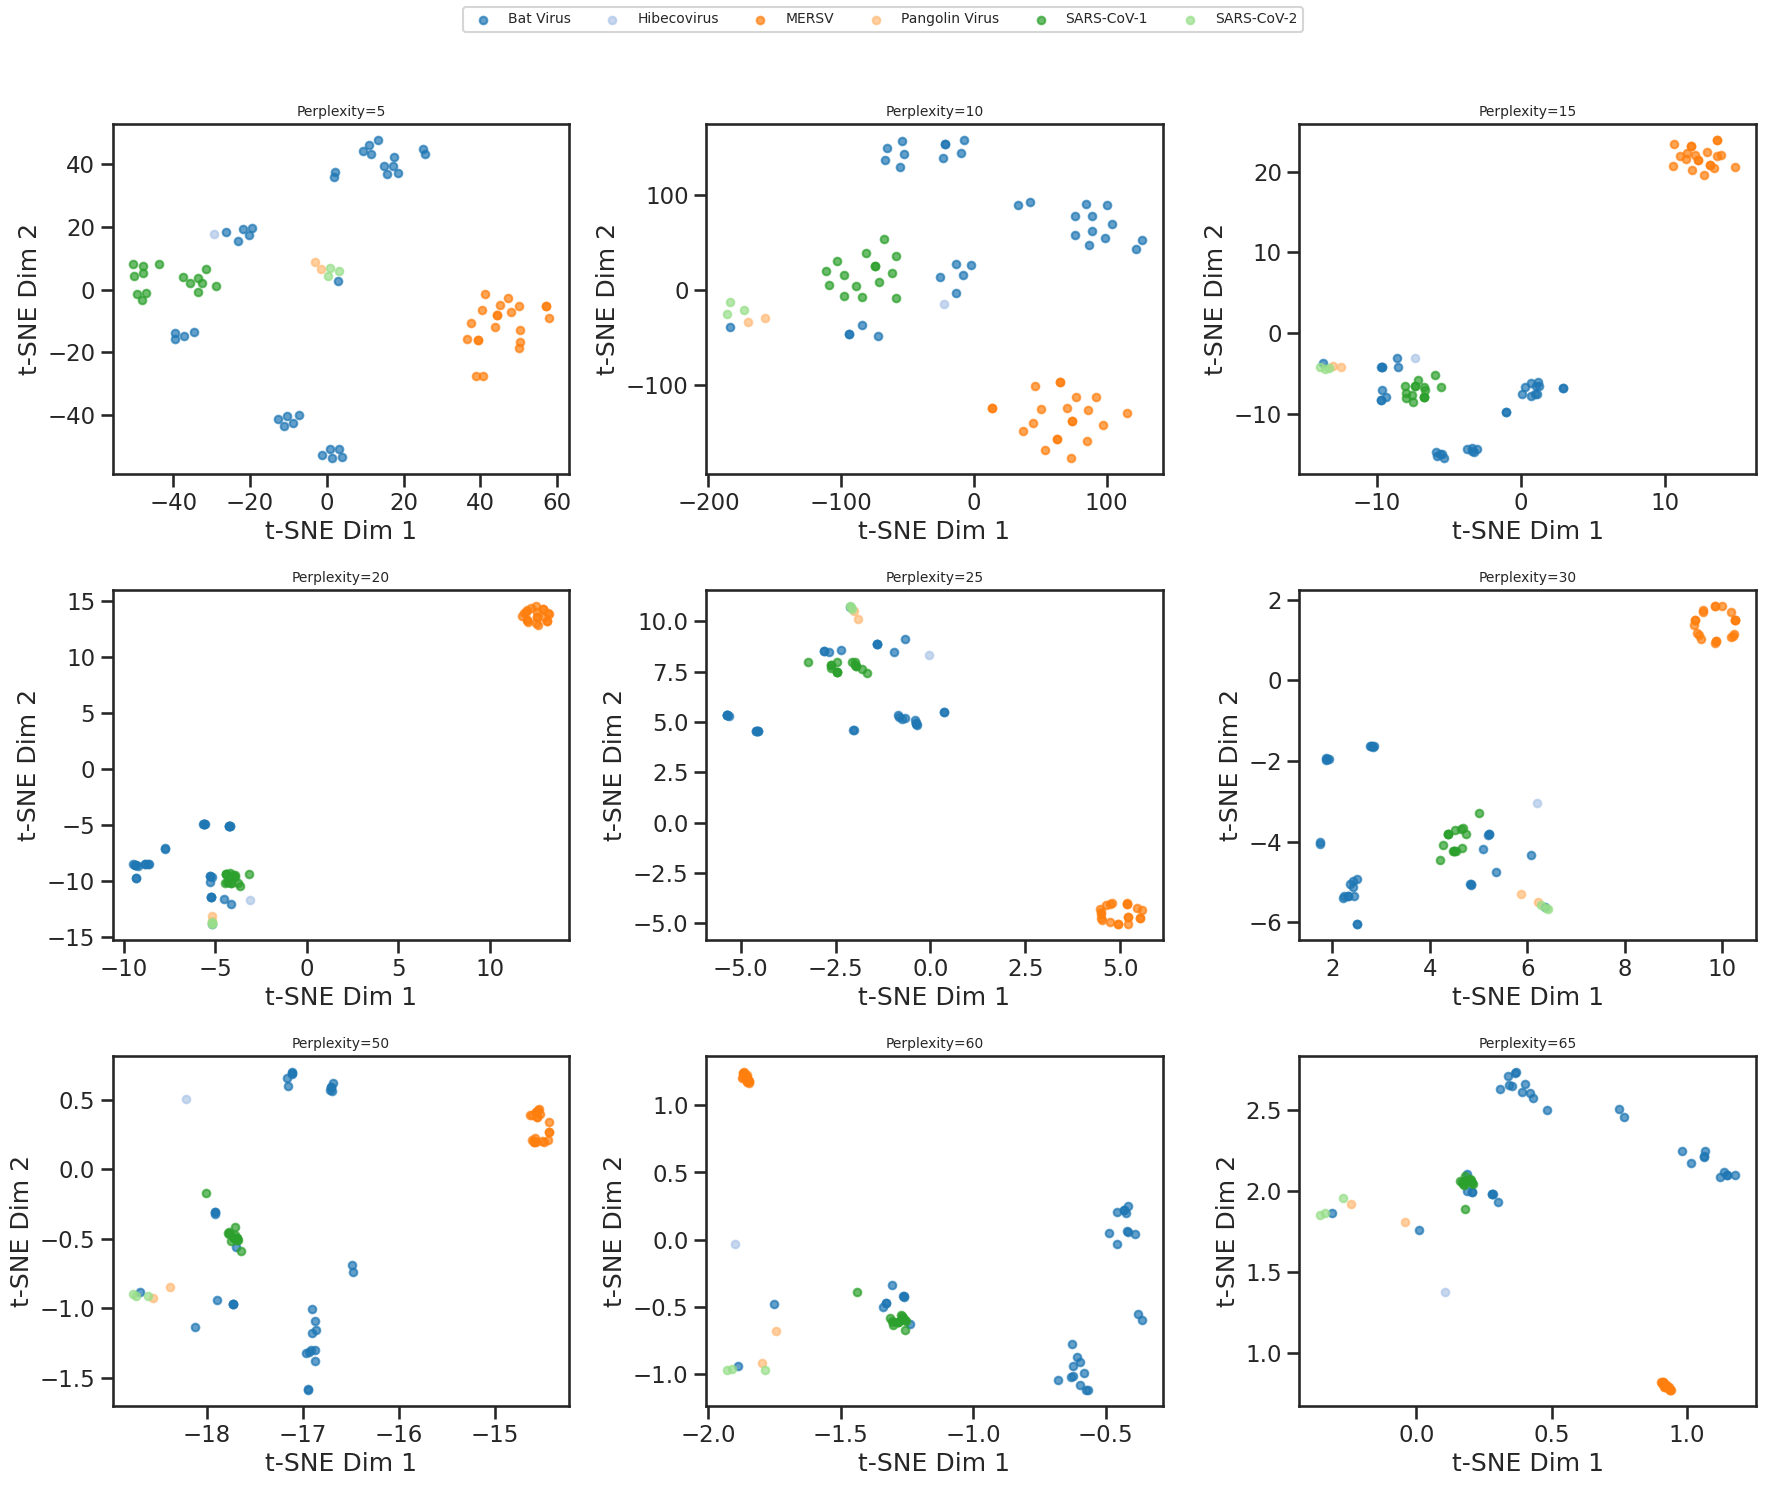

In [87]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_tsne_grid(info_df, embedding_matrix, variant_column, color_map='tab20', perplexities=[5, 10, 15, 20, 25, 30, 50, 60, 65]):
    n_rows = 3
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 15))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.rcParams['font.family'] = 'sans-serif'

    variant_labels = sorted(info_df[variant_column].unique())
    colors = sns.color_palette(color_map, len(variant_labels))
    variant_colors = dict(zip(variant_labels, colors))
    variant_colors['UNSPECIFIED'] = 'black'

    for ax, perp in zip(axes.flat, perplexities):
        tsne = TSNE(n_components=2, perplexity=perp, random_state=0)
        embedding = tsne.fit_transform(embedding_matrix)
        embeddings_df = pd.DataFrame(embedding, columns=['DIM_1', 'DIM_2']).reset_index(drop=True)
        df = pd.concat([info_df, embeddings_df], axis=1)
        df['colors'] = df[variant_column].map(variant_colors)

        for variant in variant_labels:
            subset = df[df[variant_column] == variant]
            ax.scatter(subset['DIM_1'], subset['DIM_2'], 
                       label=variant, c=[variant_colors[variant]], s=30, alpha=0.7)

        ax.set_title(f'Perplexity={perp}', fontsize=10)
        ax.set_xlabel('t-SNE Dim 1')
        ax.set_ylabel('t-SNE Dim 2')

    # Only show legend once in a free axis or the last axis
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=6, fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Load in the data
data_dir = "../../data/betacov"
parquet_file = os.path.join(data_dir, f"betacoronavirus_seq_CLS-embedded.parquet")
embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix = np.vstack(embedded_df["embedding"])
info_df = embedded_df.drop(columns=["embedding"])

# Apply tSNE to reduce the dimensionality of the embedding matrix
plot_tsne_grid(info_df, embedding_matrix, variant_column='variant')

In [88]:
# Save the embedding based off best perplexity
perplexity = 65
tsne_reducer = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', random_state=0)
embedding_matrix_reduced = tsne_reducer.fit_transform(embedding_matrix)

embeddings_df = pd.DataFrame(embedding_matrix_reduced, columns=['DIM_1', 'DIM_2']).reset_index(drop=True)
tsne_df = pd.concat([info_df, embeddings_df], axis=1)
save_as = os.path.join(data_dir, f"betacoronavirus_seq_CLS-embedded.tsne.parquet")
tsne_df.to_parquet(save_as, engine='fastparquet')

Load the tsne embeddings.

In [89]:
# Load the embedding
parquet_file = os.path.join(data_dir, f"betacoronavirus_seq_CLS-embedded.tsne.parquet")
embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix_reduced = embedded_df[['DIM_1', 'DIM_2']].values
info_df = embedded_df.drop(columns=['DIM_1', 'DIM_2'])

Find highest or a sufficiently highest Silhouette Coefficient, Adjusted Rand Index.

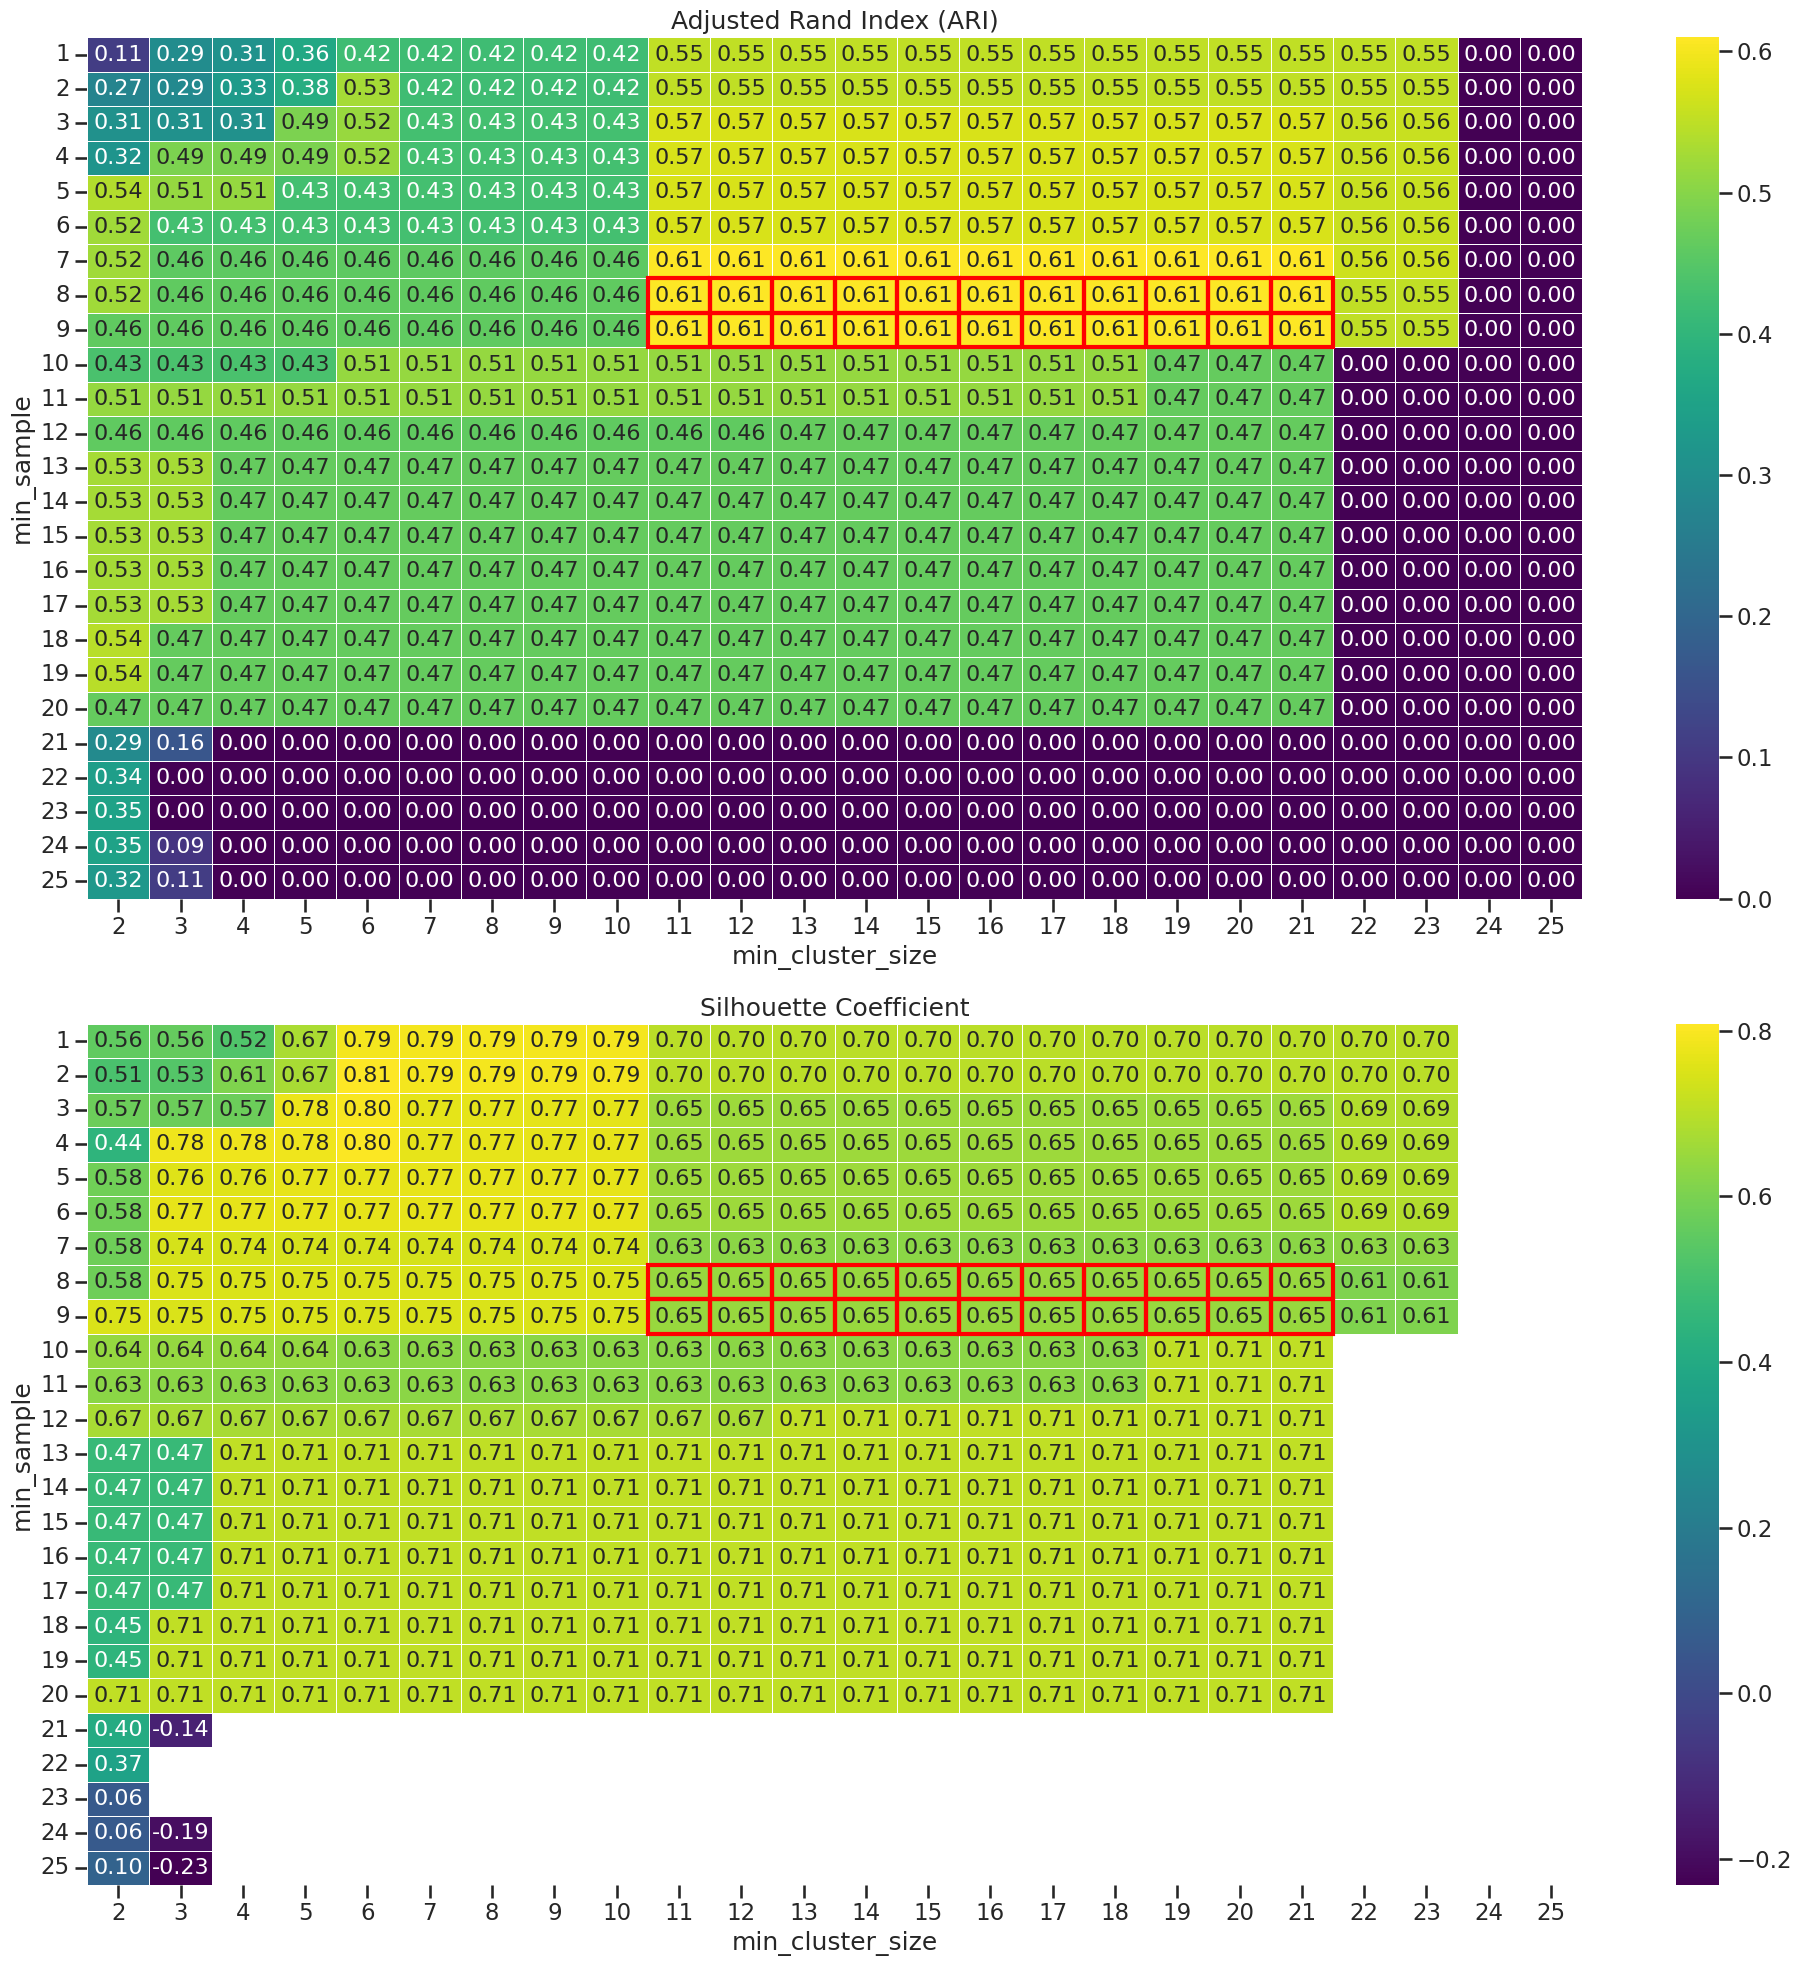

In [90]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def ari_sc_heatmap(embedding_matrix_reduced, info_df, min_samples_max=51, min_cluster_size_max=51):
    results = []

    for ms in range(1, min_samples_max):
        for mcs in range(2, min_cluster_size_max):
            # Cluster
            clusterer = hdbscan.HDBSCAN(
                min_samples=ms,
                min_cluster_size=mcs,
                core_dist_n_jobs=-1
            ).fit(embedding_matrix_reduced)

            labels = clusterer.labels_

            # Evaluate clustering
            ari = adjusted_rand_score(info_df["variant"], labels)

            # Check number of clusters (excluding noise)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters > 1:
                silhouette_avg = silhouette_score(embedding_matrix_reduced, labels)
            else:
                silhouette_avg = np.nan  # or 0, depending on how you want to treat it

            # Store results
            results.append({
                "min_sample": ms,
                "min_cluster_size": mcs,
                "ari": ari,
                "silhouette": silhouette_avg
            })

    # Convert to DataFrame
    df = pd.DataFrame(results)

    # Pivot matrices
    ari_matrix = df.pivot(index='min_sample', columns='min_cluster_size', values='ari')
    silhouette_matrix = df.pivot(index='min_sample', columns='min_cluster_size', values='silhouette')

    # Plot heatmaps
    sns.set_style('ticks')
    sns.set_context("talk")
    fig, axs = plt.subplots(2, 1, figsize=(20, 20))

    sns.heatmap(ari_matrix, annot=True, annot_kws={"size": 16}, fmt=".2f", linewidth=.5, cmap="viridis", ax=axs[0])
    axs[0].set_title("Adjusted Rand Index (ARI)")
    axs[0].set_xlabel("min_cluster_size")
    axs[0].set_ylabel("min_sample")

    max_ari = ari_matrix.max().max()  # Get the max ARI value

    for i in range(ari_matrix.shape[0]):  # min_sample (rows)
        for j in range(ari_matrix.shape[1]):  # min_cluster_size (cols)
            if np.isclose(ari_matrix.iloc[i, j], max_ari):  # Safe float comparison
                axs[0].add_patch(
                    plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=3)
                )

    sns.heatmap(silhouette_matrix, annot=True, annot_kws={"size": 16}, fmt=".2f", linewidth=.5, cmap="viridis", ax=axs[1])
    axs[1].set_title("Silhouette Coefficient")
    axs[1].set_xlabel("min_cluster_size")
    axs[1].set_ylabel("min_sample")

    for i in range(ari_matrix.shape[0]):  # min_sample (rows)
        for j in range(ari_matrix.shape[1]):  # min_cluster_size (cols)
            if np.isclose(ari_matrix.iloc[i, j], max_ari):  # Safe float comparison
                axs[1].add_patch(
                    plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=3)
                )
    plt.tight_layout()
    plt.show()

ari_sc_heatmap(embedding_matrix_reduced, info_df, min_samples_max=26, min_cluster_size_max=26)

Plotting the tSNE embeddings after applying HDBSCAN.

min_sample 8, min_cluster_size 16: Adjusted Rand Index: 0.61, Silhouette Coefficient: 0.65
    t-SNE component 1  t-SNE component 2  Cluster          Seq ID         Variant      Host
0           -0.310656           1.864960       -1        MN996532       Bat Virus       Bat
1            0.365045           2.731015        2        MG772934       Bat Virus       Bat
2            0.368208           2.736597        2        MG772933       Bat Virus       Bat
3            0.203687           1.991848        1        KT444582       Bat Virus       Bat
4            0.279580           1.980720        1        KY417146       Bat Virus       Bat
5            0.203687           1.991848        1        KF367457       Bat Virus       Bat
6            0.188162           1.998910        1        KY417151       Bat Virus       Bat
7            0.278826           1.984134        1        KY417144       Bat Virus       Bat
8            0.282172           1.982657        1        KC881005       Bat Virus

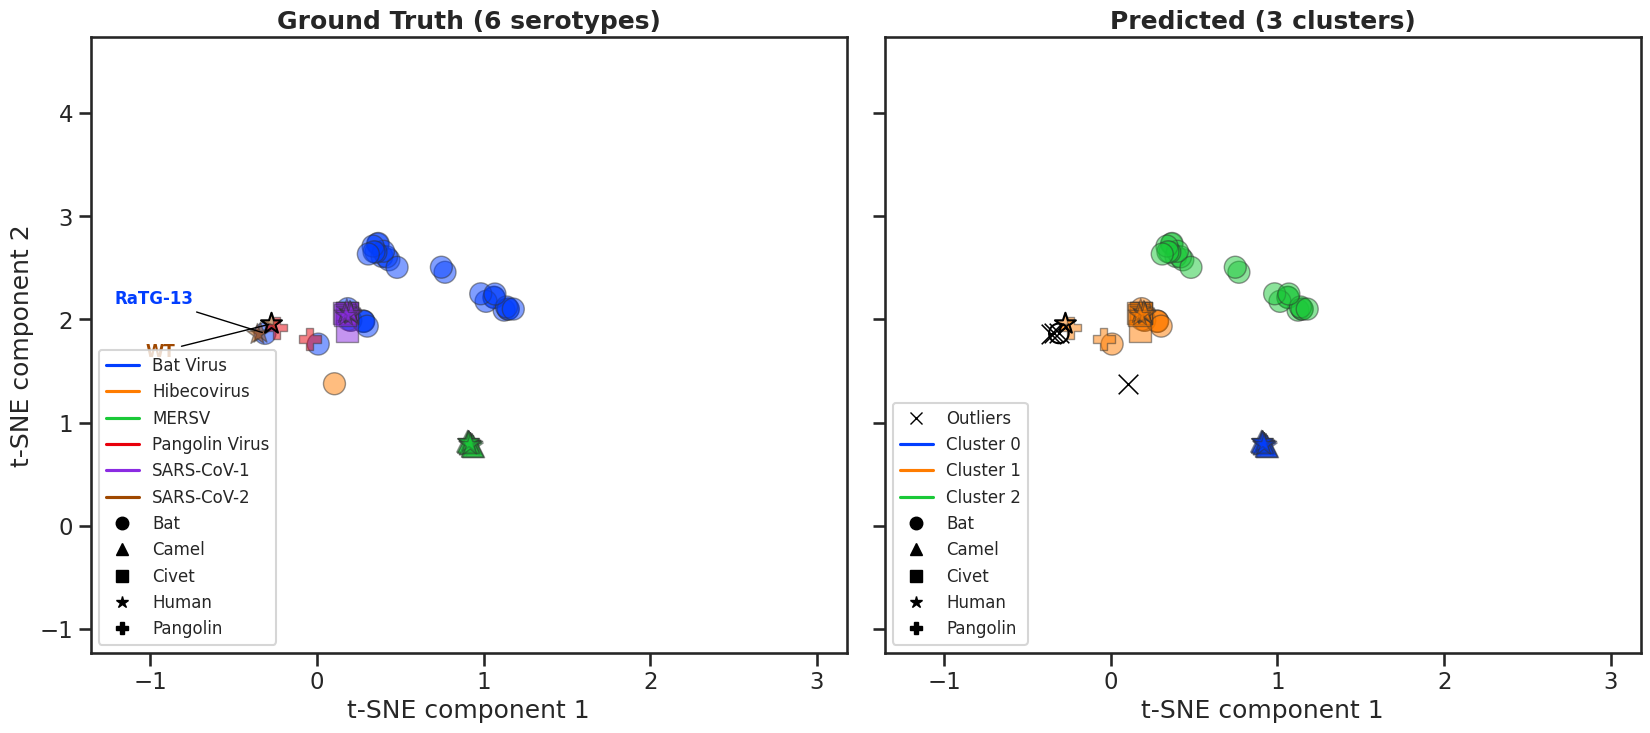

Predicted Clusters,-1,0,1,2
Ground Truth,,,,
Bat Virus,3.03,0.0,27.27,69.7
Hibecovirus,100.00,0.0,0.00,0.0
MERSV,0.00,100.0,0.00,0.0
Pangolin Virus,0.00,0.0,100.00,0.0
SARS-CoV-1,0.00,0.0,100.00,0.0
SARS-CoV-2,66.67,0.0,33.33,0.0


In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_groundtruth_prediction_1x2(embedding_matrix, info_df, hdb_labels, annotation_labels, save_as, x_min_width_buffer=2, colormap="colorblind"):
    # Create a DataFrame for easier plotting
    plot_df = pd.DataFrame({
        't-SNE component 1': embedding_matrix[:, 0],
        't-SNE component 2': embedding_matrix[:, 1],
        'Cluster': hdb_labels,
        'Seq ID': info_df['seq_id'],
        'Variant': info_df['variant'],
        'Host': info_df['host'],
    })

    print(plot_df.to_string())

    # Define a host shape palette
    unique_hosts = np.unique(plot_df['Host'])
    host_marker_palette = ['o', '^', 's', '*', 'P', 'D', 'v', 'p', '.', '>', '<', 'd', 'H', 'h', '8']   # Use only filled markers
    host_marker_dict = {label: marker for label, marker in zip(unique_hosts, host_marker_palette)}
    marker_size = 250
    
    # Define a variant color palette
    unique_variants = np.unique(plot_df['Variant'])
    variant_color_palette = sns.color_palette(colormap, n_colors=len(unique_variants)) 
    variant_color_dict = {label: color for label, color in zip(unique_variants, variant_color_palette)}

    # Define a cluster color palette
    unique_clusters = np.unique(plot_df['Cluster'])
    cluster_color_palette = sns.color_palette(colormap, n_colors=len(unique_clusters)) 
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_color_palette)}
    cluster_color_dict[-1] = 'black'  # Set outliers to x

    sns.set_style('ticks')
    sns.set_context("talk")
    fig, axs = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    fig.subplots_adjust(wspace=0.05)  # Reduce the horizontal space between subplots

    #####################################################

    # Scatterplot
    sns.scatterplot(
        data=plot_df,
        x='t-SNE component 1', y='t-SNE component 2',
        hue='Variant', palette=variant_color_dict, 
        style='Host', markers=host_marker_dict,  
        s=marker_size, alpha=0.5, edgecolor=".2", linewidth=1,
        ax=axs[0]
    )

    # Outline points in black 
    annotate_df = plot_df[plot_df['Seq ID'].isin(annotation_labels)]
    sns.scatterplot(
        data=annotate_df[annotate_df['Cluster'] != -1],
        x='t-SNE component 1', y='t-SNE component 2',
        style='Host', markers=host_marker_dict,  
        s=marker_size, edgecolor='black', facecolor='none', linewidth=1.5,
        ax=axs[0]
    )

    # Annotate multi-serotype points
    for idx, row in annotate_df.iterrows():
        if row['Seq ID'] in annotation_labels:  # Only annotate specified labels
            x, y = row['t-SNE component 1'], row['t-SNE component 2']
            if row['Seq ID'] == 'MN908947': label = "WT"
            if row['Seq ID'] == 'MN996532': label = "RaTG-13"
            x_offset, y_offset = annotation_labels.get(row['Seq ID']) 
                        
            axs[0].annotate(
                label, 
                (x, y), xytext=(x_offset, y_offset), textcoords='offset points',
                color=variant_color_dict[row['Variant']],
                fontsize=12, fontweight='bold', ha='center', va='center',
                arrowprops=dict(arrowstyle="-", color='k', lw=1)
            )

    axs[0].set_title(f"Ground Truth ({len(unique_variants)} serotypes)", ha='center', fontweight='bold')
    axs[0].set_xlim((plot_df['t-SNE component 1'].min()-x_min_width_buffer, plot_df['t-SNE component 1'].max()+2))
    axs[0].set_ylim(plot_df['t-SNE component 2'].min()-2, plot_df['t-SNE component 2'].max()+2),

    # Legend 
    host_handles = [
        plt.Line2D([0], [0], marker=host_marker_dict[host], color='black', linestyle='none', label=f'{host}')
        for host in unique_hosts
    ]
    variant_handles = [
        plt.Line2D([0], [0], color=variant_color_dict[variant], label=f'{variant}')
        for variant in unique_variants
    ]
    axs[0].legend(handles=variant_handles+host_handles)
    sns.move_legend(axs[0], "lower left", fontsize=12)
    
    # #####################################################

    # Scatterplot for non-outliers
    sns.scatterplot(
        data=plot_df[plot_df['Cluster'] != -1],  # Exclude outliers
        x='t-SNE component 1', y='t-SNE component 2',
        hue='Cluster', palette=cluster_color_dict, 
        style='Host', markers=host_marker_dict,
        s=marker_size, alpha=0.5, edgecolor=".2", linewidth=1,
        ax=axs[1]
    )

    # Scatterplot for outliers (Cluster = -1)
    sns.scatterplot(
        data=plot_df[plot_df['Cluster'] == -1],  # Select only outliers
        x='t-SNE component 1', y='t-SNE component 2',
        marker='x',
        s=marker_size-50, color='black',
        ax=axs[1]
    )

    # Outline points in black 
    annotate_df = plot_df[plot_df['Seq ID'].isin(annotation_labels)]
    sns.scatterplot(
        data=annotate_df[annotate_df['Cluster'] != -1],
        x='t-SNE component 1', y='t-SNE component 2',
        style='Host', markers=host_marker_dict,  
        s=marker_size, edgecolor='black', facecolor='none', linewidth=1.5,
        ax=axs[1]
    )

    sns.scatterplot(
        data=annotate_df[annotate_df['Cluster'] == -1],
        x='t-SNE component 1', y='t-SNE component 2',
        style='Host', markers=host_marker_dict,  
        s=marker_size-50, edgecolor='black', facecolor='none', linewidth=1.5,
        ax=axs[1]
    )

    axs[1].set_title(f"Predicted ({len(unique_clusters[unique_clusters != -1])} clusters)", ha='center', fontweight='bold')
    axs[1].set_xlim((plot_df['t-SNE component 1'].min()-x_min_width_buffer, plot_df['t-SNE component 1'].max()+2))
    axs[1].set_ylim(plot_df['t-SNE component 2'].min()-2, plot_df['t-SNE component 2'].max()+2),

    # Legend 
    host_handles = [
        plt.Line2D([0], [0], marker=host_marker_dict[host], color='black', linestyle='none', label=f'{host}')
        for host in unique_hosts
    ]
    cluster_handles = [plt.Line2D([0], [0], marker='x', color='black', linestyle='none', label='Outliers')]
    cluster_handles += [
        plt.Line2D([0], [0], color=cluster_color_dict[cluster], label=f'Cluster {cluster}')
        for cluster in unique_clusters if cluster != -1
    ]
    axs[1].legend(handles=cluster_handles+host_handles)
    sns.move_legend(axs[1], "lower left", fontsize=12)

    #####################################################
  
    plt.savefig(f"{save_as}.pdf", format="pdf", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_as}.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()

min_samples=8
min_cluster_size=16

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
ari = adjusted_rand_score(info_df["variant"], hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Adjusted Rand Index: {ari:.2f}, Silhouette Coefficient: {silhouette_avg:.2f}")
save_as = f"BETACOV.tSNE-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-ari{ari:.2f}_sc{silhouette_avg:.2f}"

# Call the function
annotation_labels = {
    'MN908947': (-80, -20),
    'MN996532': (-80, 25),
}
plot_groundtruth_prediction_1x2(embedding_matrix_reduced, info_df, hdb_labels, annotation_labels, save_as, x_min_width_buffer=1, colormap="bright")

# Create the truth table
truth_table_percent = pd.crosstab(info_df["variant"], hdb_labels, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'],
                                normalize='index')  # Normalize along the index (rows)
truth_table_percent = (truth_table_percent * 100).round(2)
truth_table_percent